# Import Library

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00


In [ ]:
pip install statsmodels

In [ ]:
# paket-paket untuk melakukan pengolahan terhadap datasets
import numpy as np
import pandas as pd
from google.colab import files
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

# paket-paket untuk memvisualisasi datasets
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf

# Cleansing data

In [ ]:
# upload datasets
df_sales = pd.read_csv("EV Truck - EV Sales.csv")
df_sales.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Austria,Historical,EV sales,Trucks,BEV,2018,Vehicles,10
1,Austria,Historical,EV sales,Trucks,BEV,2019,Vehicles,2
2,Austria,Historical,EV sales,Trucks,BEV,2021,Vehicles,38
3,Austria,Historical,EV sales,Trucks,BEV,2022,Vehicles,57
4,Belgium,Historical,EV sales,Trucks,BEV,2011,Vehicles,1


In [ ]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   region      205 non-null    object
 1   category    205 non-null    object
 2   parameter   205 non-null    object
 3   mode        205 non-null    object
 4   powertrain  205 non-null    object
 5   year        205 non-null    int64 
 6   unit        205 non-null    object
 7   value       205 non-null    object
dtypes: int64(1), object(7)
memory usage: 12.9+ KB


In [ ]:
#mengecek adanya duplicate value
df_sales.duplicated().sum()

0

Dapat dilihat bahwa tidak terdapat missing value & duplicate value

In [ ]:
# Mengganti koma (,) dengan titik (.) dan mengonversi kolom 'value' menjadi integer
df_sales['value'] = df_sales['value'].str.replace(',', '.').astype(float).round().astype(int)
print(df_sales)

      region    category parameter    mode powertrain  year      unit  value
0    Austria  Historical  EV sales  Trucks        BEV  2018  Vehicles     10
1    Austria  Historical  EV sales  Trucks        BEV  2019  Vehicles      2
2    Austria  Historical  EV sales  Trucks        BEV  2021  Vehicles     38
3    Austria  Historical  EV sales  Trucks        BEV  2022  Vehicles     57
4    Belgium  Historical  EV sales  Trucks        BEV  2011  Vehicles      1
..       ...         ...       ...     ...        ...   ...       ...    ...
200    World  Historical  EV sales  Trucks       PHEV  2020  Vehicles    420
201    World  Historical  EV sales  Trucks       PHEV  2021  Vehicles   1000
202    World  Historical  EV sales  Trucks        BEV  2021  Vehicles  40000
203    World  Historical  EV sales  Trucks        BEV  2022  Vehicles  58000
204    World  Historical  EV sales  Trucks       PHEV  2022  Vehicles   1500

[205 rows x 8 columns]


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc2877691b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc2877696f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc287768f10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc287769c30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc287769ed0>],
 'means': []}

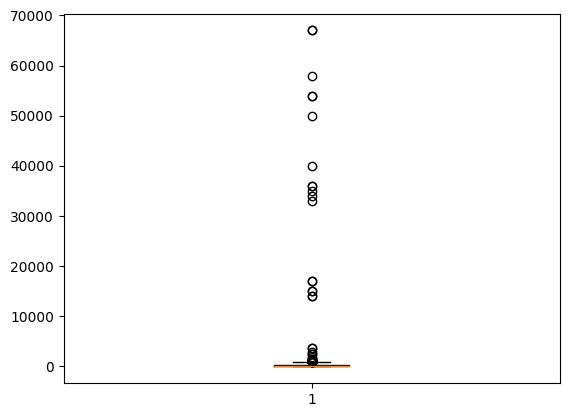

In [ ]:
# mengecek outlier
plt.boxplot(df_sales['value'])

tidak terdapat outlier

In [ ]:
df_sales['value'].unique()

array([   10,     2,    38,    57,     1,     3,    20,    40,    23,
          15,  1300,     8,     6,     9,     7,   900,     5,   100,
         430,   860,   340, 17000, 15000, 14000, 67000, 54000,  3600,
        2400, 35000, 33000,   420,  1000, 36000, 50000,  1500,     4,
          27,    37,    26,    19,    13,   330,   710,   960,    16,
        1900,    18,    17,    34,    33,    25,    31,    12,   760,
        2800,    70,   500,   280,   610,   850,   990,   830,    29,
          11,    50,    35,    28,    73,    39,    64,   120,    24,
          41,   360,   150,   180,   510,   300,   450,   910,   380,
       34000, 40000, 58000])

In [ ]:
# membuat data csv yang telah di cleansing untuk data pembuatan dashboard
df_sales.to_csv('EV Sales Truck.csv', index=False)

In [ ]:
# files.download('EV Sales Truck.csv')

# Data Transformation and Feature Engineering

Membuat dataframe baru untuk proses forecasting

In [ ]:
df = df_sales[['year','region', 'value']]

In [ ]:
df = df.groupby(['year','region'])['value'].sum().reset_index()

In [ ]:
df['year'] = pd.to_datetime(df['year'], format='%Y')

In [ ]:
df['year'] = df['year'].apply(lambda x: x.replace(month= 12, day=31))

In [ ]:
df = df.set_index('year')
df

,region,value
year,,
2010-12-31,Canada,1
2010-12-31,China,5
2010-12-31,Denmark,4
2010-12-31,EU27,8
2010-12-31,Europe,18
...,...,...
2022-12-31,Poland,6
2022-12-31,Spain,150
2022-12-31,Sweden,187


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 181 entries, 2010-12-31 to 2022-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   region  181 non-null    object
 1   value   181 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [ ]:
df['region'].unique()

array(['Canada', 'China', 'Denmark', 'EU27', 'Europe', 'Iceland', 'Italy',
       'Netherlands', 'United Kingdom', 'World', 'Belgium', 'Poland',
       'Other Europe', 'Spain', 'Finland', 'France', 'Norway', 'Austria',
       'Brazil', 'Germany', 'Japan', 'Rest of the world', 'Sweden',
       'New Zealand', 'Switzerland', 'Korea', 'Israel', 'Mexico'],
      dtype=object)

In [ ]:
# Memisahkan dataframe berdasarkan region agar dapat di lakukan forecasting berdasarkan region
df_Austria = df[df['region'] == 'Austria']
df_Belgium = df[df['region'] == 'Belgium']
df_Brazil = df[df['region'] == 'Brazil']
df_Canada = df[df['region'] == 'Canada']
df_China = df[df['region'] == 'China']
df_Denmark = df[df['region'] == 'Denmark']
df_EU27 = df[df['region'] == 'EU27']
df_Europe = df[df['region'] == 'Europe']
df_Finland = df[df['region'] == 'Finland']
df_France = df[df['region'] == 'France']
df_Germany = df[df['region'] == 'Germany']
df_Iceland = df[df['region'] == 'Iceland']
df_Israel = df[df['region'] == 'Israel']
df_Italy = df[df['region'] == 'Italy']
df_Japan = df[df['region'] == 'Japan']
df_Korea = df[df['region'] == 'Korea']
df_Mexico = df[df['region'] == 'Mexico']
df_Netherlands = df[df['region'] == 'Netherlands']
df_New_Zealand = df[df['region'] == 'New Zealand']
df_Norway = df[df['region'] == 'Norway']
df_Poland = df[df['region'] == 'Poland']
df_Spain = df[df['region'] == 'Spain']
df_Sweden = df[df['region'] == 'Sweden']
df_Switzerland = df[df['region'] == 'Switzerland']
df_UK = df[df['region'] == 'United Kingdom']

# Exploratory Data Analysis (EDA)

#Exploratory Data Analysis (EDA)

In [ ]:
import plotly.express as px

df_year = df_sales.groupby('year')['value'].sum().reset_index()

# Membuat bar chart interaktif dengan Plotly Express
fig = px.bar(df_year, x='year', y='value', title='Total Penjualan per Tahun', text='value')

# Menambahkan label pada sumbu x dan y
fig.update_xaxes(title_text='Tahun')
fig.update_yaxes(title_text='Total Penjualan')

# Menambahkan label pada bar chart
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Menampilkan grafik interaktif
fig.show()

In [ ]:
# Membuat line chart interaktif dengan Plotly Express
fig = px.line(df_year, x='year', y='value', title='Penjualan per Tahun')

# Menambahkan label pada sumbu x dan y
fig.update_xaxes(title_text='Tahun')
fig.update_yaxes(title_text='Total Penjualan')

# Menampilkan grafik interaktif
fig.show()

In [ ]:
df_region_year = df_sales.groupby(['year', 'region'])['value'].sum().reset_index()

# Membuat stacked bar chart interaktif dengan Plotly Express
fig = px.bar(df_region_year, x='year', y='value', color='region', title='Penjualan per Tahun di Setiap Region')

# Menambahkan label pada sumbu x dan y
fig.update_xaxes(title_text='Tahun')
fig.update_yaxes(title_text='Total Penjualan')

# Menampilkan grafik interaktif
fig.show()

In [ ]:
df_powertrain = df_sales.groupby(['powertrain'])['value'].sum().reset_index()

# Membuat pie chart interaktif dengan Plotly Express
fig = px.pie(df_powertrain, names='powertrain', values='value', title='Pie Chart berdasarkan Powertrain')

# Menampilkan grafik interaktif
fig.show()

In [ ]:
df_region = df_sales.groupby('region')['value'].sum().reset_index()

# Membuat bar chart interaktif dengan Plotly Express
fig = px.bar(df_region, x='region', y='value', title='Total Penjualan Tiap Region', text='value')

# Menambahkan label pada sumbu x dan y
fig.update_xaxes(title_text='Region')
fig.update_yaxes(title_text='Total Penjualan')

# Menambahkan label pada bar chart
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Menampilkan grafik interaktif
fig.show()

# Forcasting

Disini Kami Hanya mengambil 3 Region dengan peringkat tertinggi dalam penjualan EV Truck kecuali world (yaitu China, Europe, EU27)

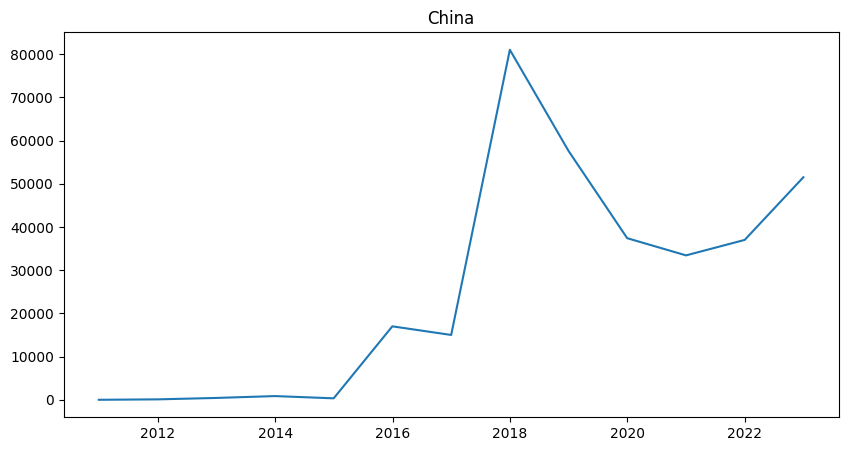

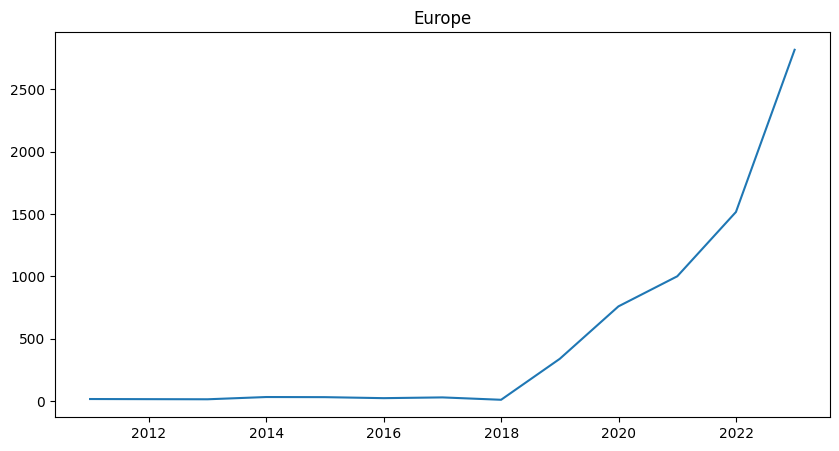

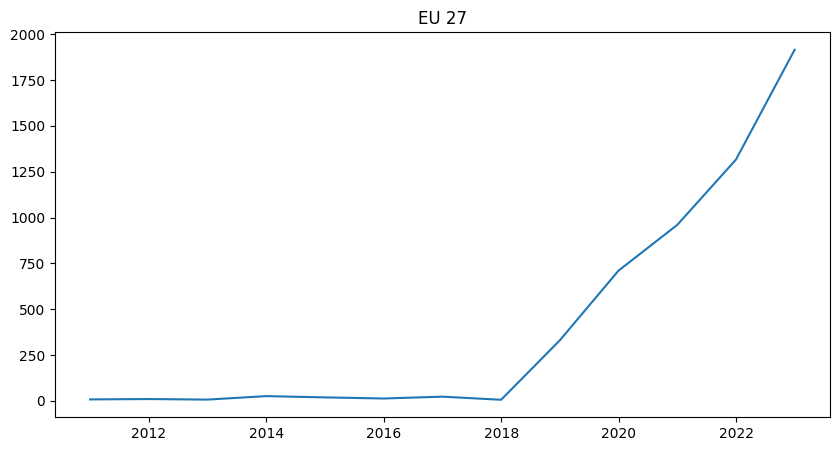

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_China['value'])
plt.title('China')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_Europe['value'])
plt.title('Europe')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_EU27['value'])
plt.title('EU 27')
plt.show()

## Mencari Nilai Parameter Arima(p,d,q) / Sarima (p,d,q,s)
Parameter pada model SARIMA terdiri dari empat komponen, yaitu:

*   p (order of autoregression): merupakan orde dari komponen autoregression (AR) pada model non-musiman. Orde ini menunjukkan jumlah lag yang akan dimasukkan ke dalam model untuk menjelaskan nilai saat ini berdasarkan nilai-nilai sebelumnya.
*   d (order of differencing): merupakan orde dari komponen differencing pada model non-musiman. Orde ini menunjukkan berapa kali data akan didifferencing agar menjadi stasioner.
*   q (order of moving average): merupakan orde dari komponen moving average (MA) pada model non-musiman. Orde ini menunjukkan jumlah lag yang akan dimasukkan ke dalam model untuk menjelaskan nilai saat ini berdasarkan nilai-nilai residual sebelumnya.
*   s (seasonality): merupakan panjang musim pada data. Komponen musiman pada model SARIMA terdiri dari parameter AR musiman, parameter MA musiman, dan orde differencing musiman. Orde differencing musiman menunjukkan berapa kali data akan didifferencing agar menjadi stasioner pada level musiman.

### Mencari parameter d

In [ ]:
# Mengetahui apakah data stasioner atau tidak (untuk data tidak stasioner maka dilakukan Differencing sampai data stasioner dan nilai d didaptkan dari berapa banyak proses Differencing)
from statsmodels.tsa.stattools import adfuller

def ad_test(data):
  dftest = adfuller(data, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ",dftest[1])
  print("3. Nums Of Lags : ",dftest[2])
  print("4. Num Of Observation Used for ADF Regression and Critical Values Calculation :",dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
    print("\t", key,":", val)
  if dftest[1] <= 0.05:
        print("Hasil: Data stasioner")
  else:
        print("Hasil: tidak stasioner")
  print(".........................................................................")

In [ ]:
ad_test(df_China['value'])
ad_test(df_Europe['value'])
ad_test(df_EU27['value'])

1. ADF :  -1.479369406276868
2. P-Value :  0.543691197867747
3. Nums Of Lags :  0
4. Num Of Observation Used for ADF Regression and Critical Values Calculation : 12
5. Critical Values :
	 1% : -4.137829282407408
	 5% : -3.1549724074074077
	 10% : -2.7144769444444443
Hasil: tidak stasioner
.........................................................................
1. ADF :  13.719634740526704
2. P-Value :  1.0
3. Nums Of Lags :  4
4. Num Of Observation Used for ADF Regression and Critical Values Calculation : 8
5. Critical Values :
	 1% : -4.6651863281249994
	 5% : -3.3671868750000002
	 10% : -2.802960625
Hasil: tidak stasioner
.........................................................................
1. ADF :  19.675761491042564
2. P-Value :  1.0
3. Nums Of Lags :  4
4. Num Of Observation Used for ADF Regression and Critical Values Calculation : 8
5. Critical Values :
	 1% : -4.6651863281249994
	 5% : -3.3671868750000002
	 10% : -2.802960625
Hasil: tidak stasioner
........................

In [ ]:
# data masih tidak stasioner maka dilakukan proses Differencing 1
diff_China = pd.Series(df_China['value']).diff().dropna()
diff_Europe = pd.Series(df_Europe['value']).diff().dropna()
diff_EU27 = pd.Series(df_EU27['value']).diff().dropna()

In [ ]:
ad_test(diff_China)
ad_test(diff_Europe)
ad_test(diff_EU27)

1. ADF :  -3.783458697933808
2. P-Value :  0.0030811613190808293
3. Nums Of Lags :  0
4. Num Of Observation Used for ADF Regression and Critical Values Calculation : 11
5. Critical Values :
	 1% : -4.223238279489106
	 5% : -3.189368925619835
	 10% : -2.729839421487603
Hasil: Data stasioner
.........................................................................
1. ADF :  6.718955548149863
2. P-Value :  1.0
3. Nums Of Lags :  4
4. Num Of Observation Used for ADF Regression and Critical Values Calculation : 7
5. Critical Values :
	 1% : -4.9386902332361515
	 5% : -3.477582857142857
	 10% : -2.8438679591836733
Hasil: tidak stasioner
.........................................................................
1. ADF :  19.075019082441962
2. P-Value :  1.0
3. Nums Of Lags :  4
4. Num Of Observation Used for ADF Regression and Critical Values Calculation : 7
5. Critical Values :
	 1% : -4.9386902332361515
	 5% : -3.477582857142857
	 10% : -2.8438679591836733
Hasil: tidak stasioner
............

In [ ]:
#proses Differencing 2
diff_Europe = pd.Series(diff_Europe).diff().dropna()
diff_EU27 = pd.Series(diff_EU27).diff().dropna()

In [ ]:
ad_test(diff_Europe)
ad_test(diff_EU27)

1. ADF :  0.07760284313210722
2. P-Value :  0.9644982464990516
3. Nums Of Lags :  3
4. Num Of Observation Used for ADF Regression and Critical Values Calculation : 7
5. Critical Values :
	 1% : -4.9386902332361515
	 5% : -3.477582857142857
	 10% : -2.8438679591836733
Hasil: tidak stasioner
.........................................................................
1. ADF :  -3.1204788730381803
2. P-Value :  0.025074314702977895
3. Nums Of Lags :  1
4. Num Of Observation Used for ADF Regression and Critical Values Calculation : 9
5. Critical Values :
	 1% : -4.473135048010974
	 5% : -3.28988060356653
	 10% : -2.7723823456790124
Hasil: Data stasioner
.........................................................................


In [ ]:
# proses Diffrencing 3
diff_Europe = pd.Series(diff_Europe).diff().dropna()

In [ ]:
ad_test(diff_Europe)

1. ADF :  -3.2818292938307074
2. P-Value :  0.015710502712138762
3. Nums Of Lags :  2
4. Num Of Observation Used for ADF Regression and Critical Values Calculation : 7
5. Critical Values :
	 1% : -4.9386902332361515
	 5% : -3.477582857142857
	 10% : -2.8438679591836733
Hasil: Data stasioner
.........................................................................


In [ ]:
# didapatkan nilai d sebagai berikut:
d1 = 1 #China
d2 = 2 #Europe
d3 = 3 #EU27

### Mencari parameter p

parameter p dapat dari berapa banyak perpotongan line chart memotong garis

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

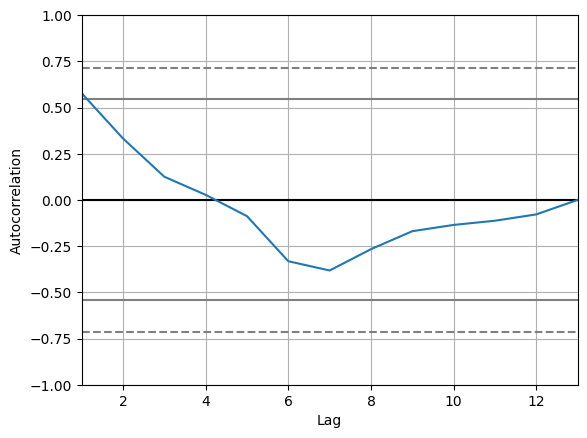

In [ ]:
#China
pd.plotting.autocorrelation_plot(df_China['value'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

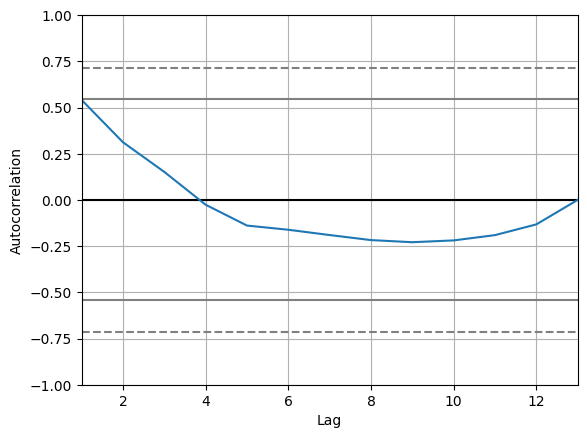

In [ ]:
#Europe
pd.plotting.autocorrelation_plot(df_Europe['value'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

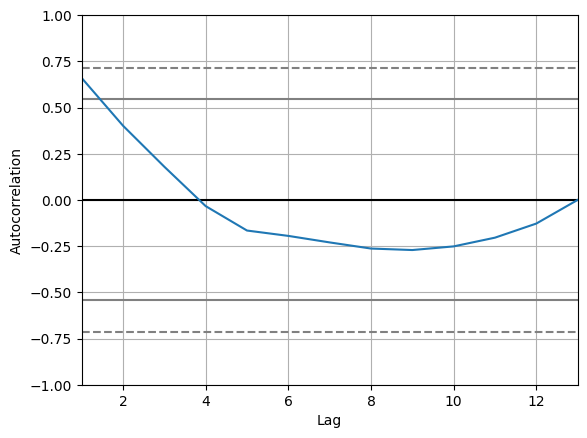

In [ ]:
#EU27
pd.plotting.autocorrelation_plot(df_EU27['value'])

In [ ]:
#didapatkan nilai p sebagai berikut:
p1 = 2 #China
p2 = 1 #Europe
p3 = 2 #EU27

### Mencari parameter q

parameter q didapat dari berapa banyak garis yang terjauh

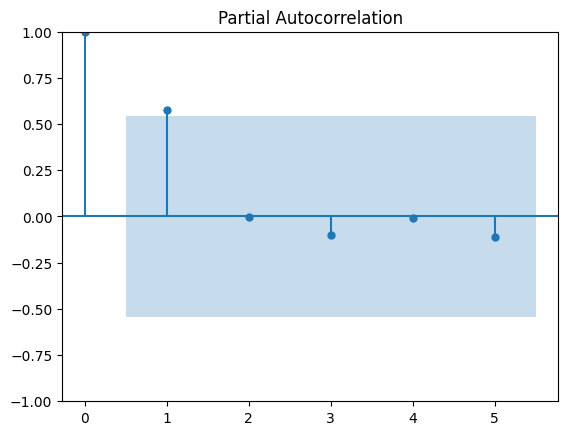

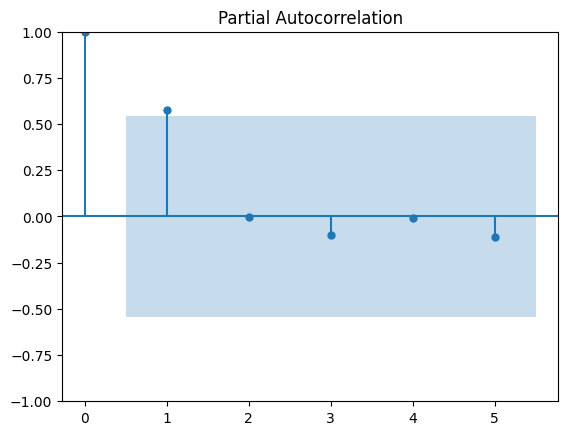

In [ ]:
#China
plot_pacf(df_China['value'],lags = 5)

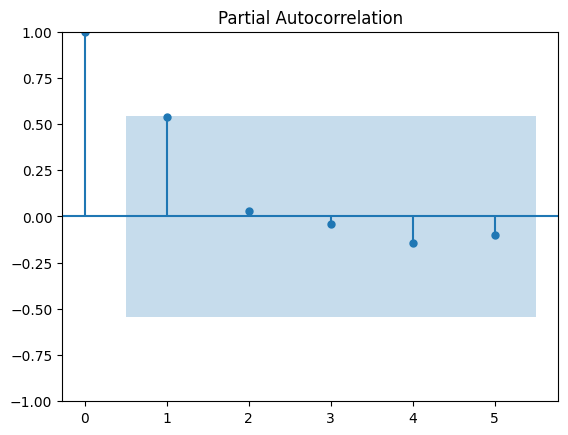

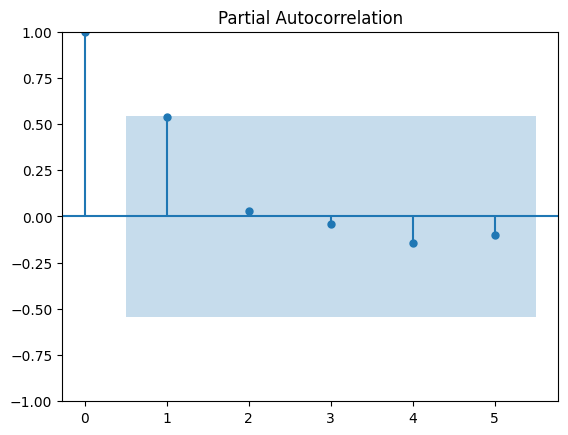

In [ ]:
#Europe
plot_pacf(df_Europe['value'],lags = 5)

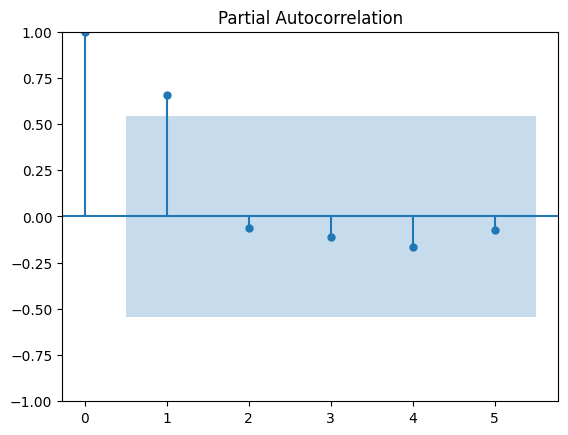

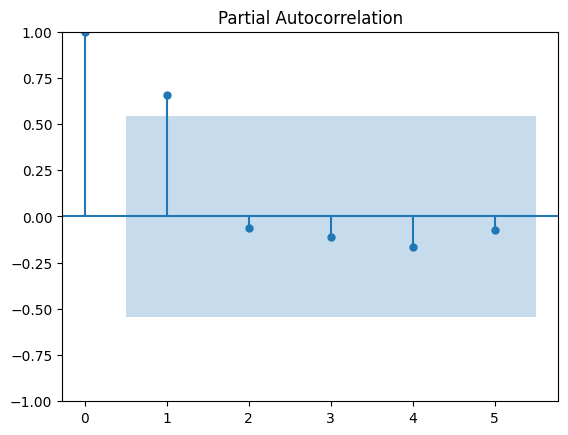

In [ ]:
#EU27
plot_pacf(df_EU27['value'],lags = 5)

In [ ]:
#didapatkan nilai q sebagai berikut:
q1 = 2 #China
q2 = 2 #Europe
q3 = 2 #EU27

## Proses Prediksi
Karena data dari 5 region tertinggi merupakan data seasonal maka dilakukan proses forecasting menggunakan metode Sarimax.

Data seasonal adalah jenis data time series yang mengalami fluktuasi atau perubahan yang terjadi secara periodik dalam kurun waktu tertentu, seperti triwulan, kuartalan, bulanan, mingguan, atau tahunan

### Region China

In [ ]:
#Latih model SARIMAX
model = SARIMAX(df_China['value'], order=(p1, d1, q1), seasonal_order=(p1, d1, q1,12))
model_fit = model.fit()

# Lakukan peramalan
tahun_terakhir = df_China.index[-1]
tahun_10_tahun_ke_depan = tahun_terakhir + pd.DateOffset(years=10)
tanggal_peramalan = pd.date_range(start=tahun_terakhir, end=tahun_10_tahun_ke_depan, freq='A')[1:]  # Exclude tahun terakhir
peramalan = model_fit.forecast(steps=len(tanggal_peramalan))

# Hasil peramalan
forecast_China = pd.DataFrame({'year': tanggal_peramalan, 'value': peramalan})

# Menggabungkan hasil prediksi dengan data historis
combined_df_China = pd.concat([df_China, forecast_China.set_index('year')])
combined_df_China

# Merapikan dataframe
combined_df_China['region'] = combined_df_China['region'].fillna('China')
combined_df_China['value'] = combined_df_China['value'].round().astype(int)
combined_df_China

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide



,region,value
year,,
2010-12-31,China,5
2011-12-31,China,100
2012-12-31,China,430
2013-12-31,China,860
2014-12-31,China,340
2015-12-31,China,17000
2016-12-31,China,15005
2017-12-31,China,81000
2018-12-31,China,57600


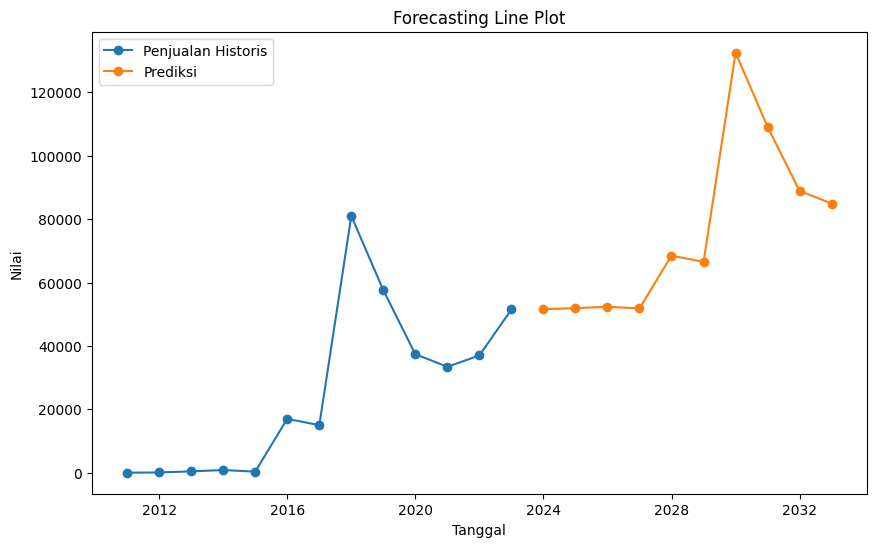

In [ ]:
# Buat plot
plt.figure(figsize=(10, 6))
plt.plot(df_China['value'], label='Penjualan Historis', marker='o')
plt.plot(forecast_China['value'], label='Prediksi', marker='o')

# Label dan Judul
plt.xlabel('Tanggal')
plt.ylabel('Nilai')
plt.title('Forecasting Line Plot')

# Menambahkan Legenda
plt.legend()

# Menampilkan Plot
plt.show()

### Region Europe

In [ ]:
#Latih model SARIMAX
model = SARIMAX(df_Europe['value'], order=(p2, d2, q2), seasonal_order=(p2, d2, q2,12))
model_fit = model.fit()

# Lakukan peramalan
tahun_terakhir = df_Europe.index[-1]
tahun_10_tahun_ke_depan = tahun_terakhir + pd.DateOffset(years=10)
tanggal_peramalan = pd.date_range(start=tahun_terakhir, end=tahun_10_tahun_ke_depan, freq='A')[1:]  # Exclude tahun terakhir
peramalan = model_fit.forecast(steps=len(tanggal_peramalan))

# Hasil peramalan
forecast_Europe = pd.DataFrame({'year': tanggal_peramalan, 'value': peramalan})

# Menggabungkan hasil prediksi dengan data historis
combined_df_Europe = pd.concat([df_Europe, forecast_Europe.set_index('year')])
combined_df_Europe

# Merapikan dataframe
combined_df_Europe['region'] = combined_df_Europe['region'].fillna('Europe')
combined_df_Europe['value'] = combined_df_Europe['value'].round().astype(int)
combined_df_Europe

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



,region,value
year,,
2010-12-31,Europe,18
2011-12-31,Europe,17
2012-12-31,Europe,16
2013-12-31,Europe,34
2014-12-31,Europe,33
2015-12-31,Europe,25
2016-12-31,Europe,31
2017-12-31,Europe,12
2018-12-31,Europe,340


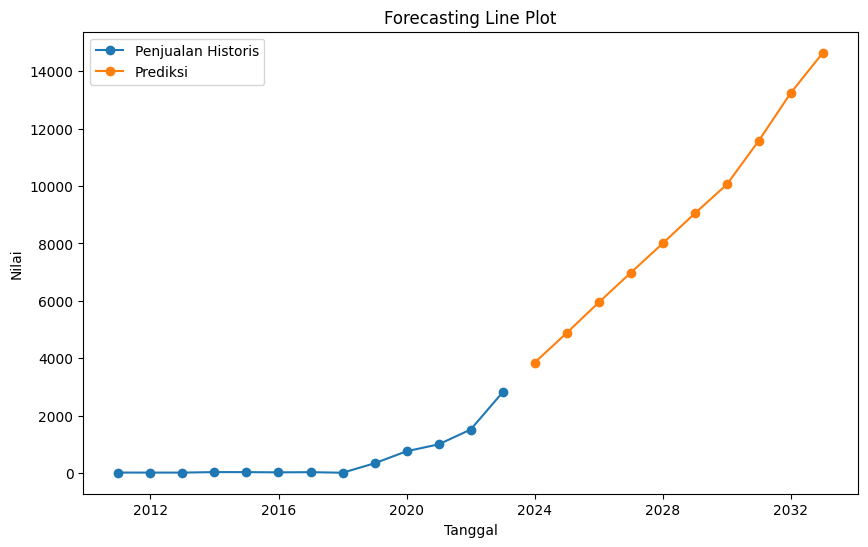

In [ ]:
# Buat plot
plt.figure(figsize=(10, 6))
plt.plot(df_Europe['value'], label='Penjualan Historis', marker='o')
plt.plot(forecast_Europe['value'], label='Prediksi', marker='o')

# Label dan Judul
plt.xlabel('Tanggal')
plt.ylabel('Nilai')
plt.title('Forecasting Line Plot')

# Menambahkan Legenda
plt.legend()

# Menampilkan Plot
plt.show()

### Region EU27

In [ ]:
#Latih model SARIMAX
model = SARIMAX(df_EU27['value'], order=(p3, d3, q3), seasonal_order=(p3, d3, q3,12))
model_fit = model.fit()

# Lakukan peramalan
tahun_terakhir = df_EU27.index[-1]
tahun_10_tahun_ke_depan = tahun_terakhir + pd.DateOffset(years=10)
tanggal_peramalan = pd.date_range(start=tahun_terakhir, end=tahun_10_tahun_ke_depan, freq='A')[1:]  # Exclude tahun terakhir
peramalan = model_fit.forecast(steps=len(tanggal_peramalan))

# Hasil peramalan
forecast_EU27 = pd.DataFrame({'year': tanggal_peramalan, 'value': peramalan})

# Menggabungkan hasil prediksi dengan data historis
combined_df_EU27 = pd.concat([df_EU27, forecast_EU27.set_index('year')])
combined_df_EU27

# Merapikan dataframe
combined_df_EU27['region'] = combined_df_EU27['region'].fillna('EU27')
combined_df_EU27['value'] = combined_df_EU27['value'].round().astype(int)
combined_df_EU27

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



,region,value
year,,
2010-12-31,EU27,8
2011-12-31,EU27,10
2012-12-31,EU27,7
2013-12-31,EU27,26
2014-12-31,EU27,19
2015-12-31,EU27,13
2016-12-31,EU27,23
2017-12-31,EU27,6
2018-12-31,EU27,330


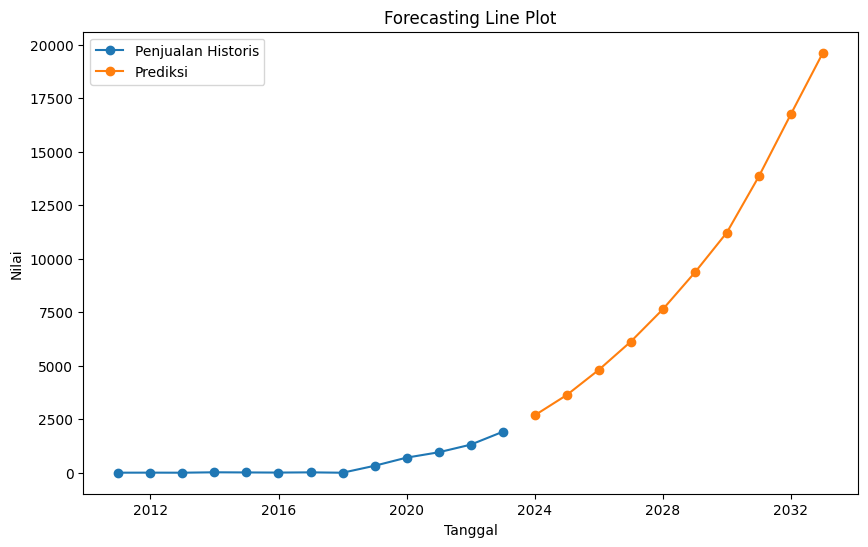

In [ ]:
# Buat plot
plt.figure(figsize=(10, 6))
plt.plot(df_EU27['value'], label='Penjualan Historis', marker='o')
plt.plot(forecast_EU27['value'], label='Prediksi', marker='o')

# Label dan Judul
plt.xlabel('Tanggal')
plt.ylabel('Nilai')
plt.title('Forecasting Line Plot')

# Menambahkan Legenda
plt.legend()

# Menampilkan Plot
plt.show()

## Data Hasil forecasting

In [ ]:
data_Forecast = pd.concat([combined_df_China, combined_df_Europe, combined_df_EU27])
data_Forecast

,region,value
year,,
2010-12-31,China,5
2011-12-31,China,100
2012-12-31,China,430
2013-12-31,China,860
2014-12-31,China,340
...,...,...
2028-12-31,EU27,9355
2029-12-31,EU27,11220
2030-12-31,EU27,13841
